##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from bs4 import BeautifulSoup
import re
import unidecode
from nltk.tokenize import TweetTokenizer
from string import punctuation
import contractions
from sklearn.feature_extraction.text import CountVectorizer
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [ ]:

#Read the CSV datafiles (Train and Test).
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [7]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [8]:
#Split data
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,Y_train,test_size=0.28, random_state=30027)

In [9]:
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)
    

In [10]:
def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)


def remove_accented_chars(text):

    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text
def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text
def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i.casefold() for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


#  ps.stem(word)

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z0-9_-]+', '', text)

def preprocess(text):
    
#     text = text.replace(r'\n','').replace(r'\m','').replace(r'\r','').replace(r'\t','') 
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = preprocess(line) 
        res.append(line)    
    return res    
X_train_clean = prepare(X_train)
X_valid_clean = prepare(X_valid) 


### Preprocessing: Vectorization
**Bag of Words (BoW)**

In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [11]:


BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_12 = BoW_vectorizer_12.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12 = BoW_vectorizer_12.transform(X_valid_clean)


**TFIDF**

In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [12]:


tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_12 = tfidf_vectorizer.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_tfidf_12 = tfidf_vectorizer.transform(X_valid_clean)


### Preprocessing: feature selection 
**select kbest + chi2** 

In [13]:


def chi(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_chi_12 = selector.transform(X_valid_BoW_12)

    return x_train_chi_12, x_test_chi_12



### Compare BoW and TFIDF


In [14]:

def chi_Tfidf(k_value, X_train_tfidf,X_valid_tfidf):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Tfidf = selector.fit_transform(X_train_tfidf ,y_train)
    x_test_chi_Tfidf = selector.transform(X_valid_tfidf)

    return x_train_chi_Tfidf , x_test_chi_Tfidf
    
def chi_BoW(k_value, X_train_BoW,X_valid_BoW ):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Bow = selector.fit_transform(X_train_BoW ,y_train)
    x_test_chi_Bow = selector.transform(X_valid_BoW)

    return x_train_chi_Bow, x_test_chi_Bow


In [15]:
#TFidf vs BoW


lr_BoW = []
lr_tfidf = []
svm_BoW = []
svm_tfidf = []
NB_BoW = []
NB_tfidf = []
for k in range(200,3000,200):
    x_train_chi_Bow, x_test_chi_Bow = chi_BoW(k, X_train_BoW_12, X_valid_BoW_12)
    x_train_chi_Tfidf , x_test_chi_Tfidf = chi_Tfidf(k, X_train_tfidf_12,X_valid_tfidf_12)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_chi_Bow, y_train)
    lr1_acc = np.mean(cross_val_score(lr1,x_test_chi_Bow,y_valid,cv = 5))
    lr_BoW.append(lr1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_chi_Tfidf, y_train)
    lr2_acc = np.mean(cross_val_score(lr2,x_test_chi_Tfidf,y_valid,cv = 5))
    lr_tfidf.append(lr2_acc)
    clf1 = SVC().fit(x_train_chi_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_chi_Bow,y_valid,cv = 5))
    svm_BoW.append(clf1_acc)
    clf2 = SVC().fit(x_train_chi_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_chi_Tfidf,y_valid,cv = 5))
    svm_tfidf.append(clf2_acc)
    nb1 = MultinomialNB().fit(x_train_chi_Bow, y_train)
    nb1_acc = np.mean(cross_val_score(nb1,x_test_chi_Bow,y_valid,cv = 5))
    NB_BoW.append(nb1_acc)
    nb2 = MultinomialNB().fit(x_train_chi_Tfidf, y_train)
    nb2_acc = np.mean(cross_val_score(nb2,x_test_chi_Tfidf,y_valid,cv = 5))
    NB_tfidf.append(nb2_acc)

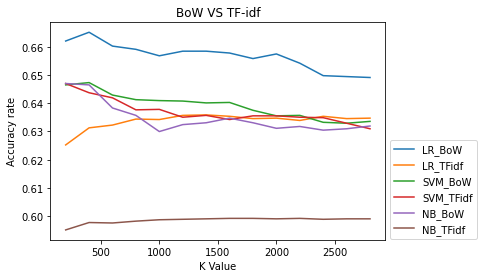

In [21]:
x = np.arange(200,3000,200)
y1 = np.array(lr_BoW )
y2 = np.array(lr_tfidf)
y3 = np.array(svm_BoW )
y4 = np.array(svm_tfidf)
y5 = np.array(NB_BoW )
y6 = np.array(NB_tfidf)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.title('BoW VS TF-idf')
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf', 'NB_BoW', 'NB_TFidf'],bbox_to_anchor=(1, 0.48))

**By obsverving the plots, K = 400 and BoW has the best perfermence.**

### Model: Logistic Regression
 

In [29]:

#Set K = 400
x_train_chi_lr, x_test_chi_lr = chi(400)

def gs_LogisticRegression(x_train):
    parameters_lr = {'solver':('newton-cg','lbfgs','sag','saga'),'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'multi_class':('auto','ovr','multinomial')}
    lr = LogisticRegression(max_iter=2000)
    gs = GridSearchCV(lr,parameters_lr)
    gs.fit(x_train,y_train)

    return gs.best_estimator_, gs.best_score_


best_estimator_lr, best_score_lr = gs_LogisticRegression(x_train_chi_lr)


In [30]:
print(f"The best estimators area: {best_estimator_lr}")
print(f"The best score is: {best_score_lr}")

The best estimators area: LogisticRegression(C=1, max_iter=2000, solver='saga')
The best score is: 0.6746513859945661


In [42]:
#C, solver, multi_class, penalty, max_iter
def logistic_regression(k_value, c_value):
    
    x_train_chi_final_lr, x_test_chi_final_lr = chi(k_value)
    #newton-cg's acc is as same as other solvers, e.g. saga
    lr = LogisticRegression(solver= 'newton-cg', C = c_value, max_iter = 2000).fit(x_train_chi_final_lr, y_train)
    y_train_predicted = lr.predict(x_train_chi_final_lr)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    lr_acc = np.mean(cross_val_score(lr,x_test_chi_final_lr,y_valid,cv = 5))
    #print('validation accuracy: ' ,lr_acc)
    # y_predicted = lr.predict(x_test_chi)
    #print('prediction accuracy: ',lr.score(x_test_chi_final, y_valid))

    return np.mean(y_train_predicted == y_train), lr_acc, lr.score(x_test_chi_final_lr, y_valid)

#ta_lr, va_lr, pa_lr = logistic_regression(400, 1)

**By observing the plots, K = 400**

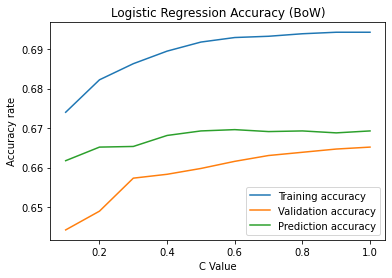

In [43]:
#Accuracy when K = 400
training_accuracy_list = []
validation_accuracy_list = []
prediction_accuracy_list = []


for i in range(1,11,1):
    ta, va, pa = logistic_regression(400, i/10)
    training_accuracy_list.append(ta)
    validation_accuracy_list.append(va)
    prediction_accuracy_list.append(pa)

x = np.arange(0.1,1.1,0.1) 
y1 = np.array(training_accuracy_list)
y2 = np.array(validation_accuracy_list)
y3 = np.array(prediction_accuracy_list)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

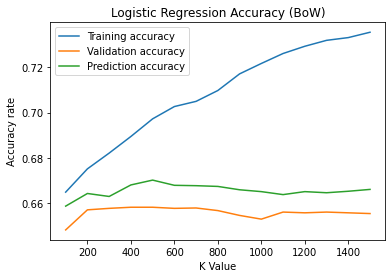

In [44]:
#Accuracy when c = 0.4
training_accuracy_list = []
validation_accuracy_list = []
prediction_accuracy_list = []


for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,0.4)
    training_accuracy_list.append(ta)
    validation_accuracy_list.append(va)
    prediction_accuracy_list.append(pa)

x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list)
y2 = np.array(validation_accuracy_list)
y3 = np.array(prediction_accuracy_list)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

In [48]:
#Finla model: K = 400, c = 0.4
#x_train_chi_final_lr, x_test_chi_final_lr = chi(400)
lr = LogisticRegression(solver= 'saga', C = 0.4, max_iter = 2000).fit(x_train_chi_lr, y_train)
y_train_predicted = lr.predict(x_train_chi_lr)
print("training accuracy ", np.mean(y_train_predicted == y_train))
lr_acc = np.mean(cross_val_score(lr,x_test_chi_lr,y_valid,cv = 5))
print('validation accuracy: ' ,lr_acc)
y_predicted = lr.predict(x_test_chi_lr)
print('prediction accuracy: ',lr.score(x_test_chi_lr, y_valid))

training accuracy  0.6901318723322928
validation accuracy:  0.6584766584766585
prediction accuracy:  0.6684684684684684


### Model: SVM



In [49]:
from sklearn.svm import SVC
x_train_chi_svm, x_test_chi_svm = chi(500)


In [244]:
gs_svc = GridSearchCV(SVC(), param_grid={"kernel":('linear', 'poly', 'rbf'), "C":[0.1,0.2,0.3,0.4,0.5,0.6],"decision_function_shape":('ovo','ovr')})  
gs_svc.fit(x_train_chi, y_train)



GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
                         'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf')})

In [245]:
print(gs_svc.best_params_)

{'C': 0.6, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [247]:
#C, kernel, degree, gamma, max_iter, decision_function_shape

clf = SVC(kernel="linear", C = 0.6, decision_function_shape = 'ovo').fit(x_train_chi_svm, y_train)
y_train_predicted = clf.predict(x_train_chi_svm)
print("training accuracy ", np.mean(y_train_predicted == y_train))
clf_acc = np.mean(cross_val_score(clf,x_test_chi_svm,y_valid,cv = 5))
print('validation accuracy: ' ,clf_acc)
# y_predicted = lr.predict(x_test_chi)
print('prediction accuracy: ',clf.score(x_test_chi_svm, y_valid))


training accuracy  0.6961839842008027
validation accuracy:  0.6494676494676493
prediction accuracy:  0.6568386568386568


In [ ]:

def gs_result_chi():
    best_params_chi = []
    best_scores_chi = []
    
    for i in range(500,2000,500):
        gs_params_chi, gs_score_chi = gs_LogisticRegression(x_train_chi)
        best_params_chi.append(gs_params_chi)
        best_scores_chi.append(gs_score_chi)

    return best_params_chi, best_scores_chi, x_train_chi, x_test_chi

best_params_chi, best_scores_chi, x_train_chi, x_test_chi = gs_result_chi()